# Dependências

In [1]:
import tensorflow as tf
import cv2

import keras

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from PIL import Image, ImageDraw, ImageFont
import sklearn
from sklearn.model_selection import train_test_split

# Utils

In [56]:
def show_image_boxes(image_path, label, bbox):

  image = cv2.imread(image_path)
  (h, w) = image.shape[:2]

  class_name = classes[decode_classes(label)]
  bbox = (bbox[0] * w, bbox[1] * h, bbox[2] * w, bbox[3] * h)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = Image.fromarray(image.astype("uint8"))

  draw = ImageDraw.Draw(image)

  draw.rectangle(bbox, outline=(0, 255, 0))

  plt.imshow(image)
  plt.title(class_name)
  plt.show()


def encode_classes(class_id):

  if ( class_id == 0):
    encoded = np.array([1,0])
  else:
    encoded = np.array([0,1])

  return encoded

def decode_classes(encoded):
  if ( encoded[0]>encoded[1]):
    return 0
  else:
    return 1

def plot_train_valid_curves(training, validation, title):

    plt.plot(training)
    plt.plot(validation)
    plt.title('model '+ title)
    plt.ylabel(title)
    plt.xlabel('epoch')
    plt.legend(['training', 'validation.'])

#Dataset

In [3]:
# Verifica se já foram baixadas as imagens do drive, baixando-as e descompactando se necessário
! [ ! -d "/content/cats_vs_dogs_obj_small" ] && gdown -O /content/cats_vs_dogs_obj_small.zip "1r52G52rLVPGZvcbNN7bjZX304GEMXVNs" &&  unzip -q /content/cats_vs_dogs_obj_small.zip -d /content && rm /content/cats_vs_dogs_obj_small.zip

# base_path = Path("/content/cats_vs_dogs_obj_small")

Downloading...
From (original): https://drive.google.com/uc?id=1r52G52rLVPGZvcbNN7bjZX304GEMXVNs
From (redirected): https://drive.google.com/uc?id=1r52G52rLVPGZvcbNN7bjZX304GEMXVNs&confirm=t&uuid=a7bb0aff-8089-4d66-9d94-78642a4be347
To: /content/cats_vs_dogs_obj_small.zip
100% 345M/345M [00:05<00:00, 63.6MB/s]


In [4]:
base_dir = "/content/cats_vs_dogs_obj_large/"
classes = ["cat", "dog"]

In [5]:
filename_list=[]
class_list = []
x1_list=[]
y1_list=[]
x2_list = []
y2_list = []

for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
      if (filename.split('.')[1]=="jpg"):
        filename_list.append(filename)
        label_file = open(base_dir+filename.split('.')[0]+'.txt', 'r')
        label = label_file.read()
        label = [int(k) for k in label.split(' ')]
        label = np.array(label)
        class_num = label[0]-1
        class_list.append(class_num)
        x1_list.append(label[1])
        y1_list.append(label[2])
        x2_list.append(label[3])
        y2_list.append(label[4])

df=pd.DataFrame()
df['filename']=filename_list
df['class_id']=class_list
df['x1']=x1_list
df['y1']=y1_list
df['x2']=x2_list
df['y2']=y2_list

# df.reset_index(drop=True, inplace=True)
# df.to_csv('images_with_boxes.csv')
df

,filename,class_id,x1,y1,x2,y2
0,scottish_terrier_172.jpg,1,68,61,268,429
1,pomeranian_109.jpg,1,200,75,295,172
2,wheaten_terrier_145.jpg,1,142,55,278,163
3,Abyssinian_111.jpg,0,298,94,423,213
4,Birman_128.jpg,0,224,103,366,234
...,...,...,...,...,...,...
3380,Russian_Blue_147.jpg,0,224,41,394,216
3381,Ragdoll_12.jpg,0,157,26,253,135
3382,scottish_terrier_108.jpg,1,173,75,320,278
3383,Ragdoll_150.jpg,0,120,3,237,131


In [6]:
HEIGHT=224
WIDTH=224

data = []
labels = []
coords = []
image_paths = []

for i in range(len(filename_list)):

  imagePath = base_dir+filename_list[i]

  image = cv2.imread(imagePath)
  (h, w) = image.shape[:2]

  image = tf.keras.preprocessing.image.load_img(imagePath, target_size=(HEIGHT, WIDTH))
  image = tf.keras.preprocessing.image.img_to_array(image)

  label = encode_classes(class_list[i])

  xmin = float(x1_list[i]) / w
  ymin = float(y1_list[i]) / h
  xmax = float(x2_list[i]) / w
  ymax = float(y2_list[i]) / h

  data.append(image)
  labels.append(label)
  coords.append((xmin, ymin, xmax, ymax))

  image_paths.append(imagePath)

data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)


coords = np.array(coords, dtype="float32")
image_paths = np.array(image_paths)

/content/cats_vs_dogs_obj_large/Maine_Coon_168.jpg
[1 0]
[0.484      0.08266667 0.8        0.448     ]


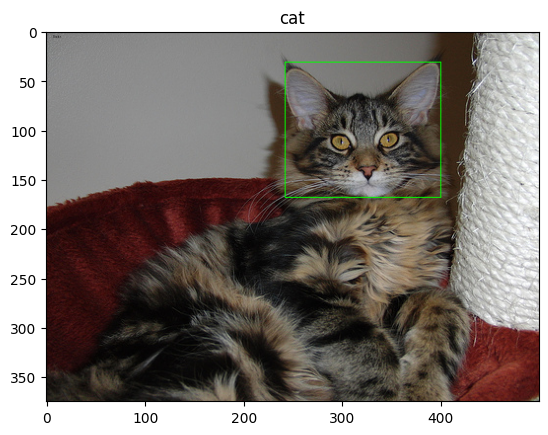

In [18]:
i = 11
print(image_paths[i])
print(labels[i])
print(coords[i])
show_image_boxes(image_paths[i], labels[i], coords[i])

#Arquitetura do Modelo

In [51]:
# Modelo YOLO simples

input_tensor = tf.keras.layers.Input(shape=(WIDTH, HEIGHT, 3))

base_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

])

x = base_model(input_tensor)

flatten = tf.keras.layers.Flatten()(x)

coordHead = tf.keras.layers.Dense(128, activation="relu")(flatten)
coordHead = tf.keras.layers.BatchNormalization()(coordHead)
coordHead = tf.keras.layers.Dropout(0.1)(coordHead)
coordHead = tf.keras.layers.Dense(32, activation="relu")(coordHead)
coordHead = tf.keras.layers.Dropout(0.2)(coordHead)
coordHead = tf.keras.layers.Dense(16, activation="relu")(coordHead)
coordHead = tf.keras.layers.Dropout(0.3)(coordHead)
coordHead = tf.keras.layers.Dense(4, activation="sigmoid", name="coords_output")(coordHead)

classHead = tf.keras.layers.Dense(2048, kernel_regularizer=tf.keras.regularizers.l2(0.001))(flatten)
classHead = tf.keras.layers.BatchNormalization()(classHead)
classHead = tf.keras.layers.Activation("relu")(classHead)
classHead = tf.keras.layers.Dropout(0.1)(classHead)

classHead = tf.keras.layers.Dense(32)(classHead)
classHead = tf.keras.layers.BatchNormalization()(classHead)
classHead = tf.keras.layers.Activation("relu")(classHead)
classHead = tf.keras.layers.Dropout(0.2)(classHead)

classHead = tf.keras.layers.Dense(32)(classHead)
classHead = tf.keras.layers.BatchNormalization()(classHead)
classHead = tf.keras.layers.Activation("relu")(classHead)
classHead = tf.keras.layers.Dropout(0.3)(classHead)

classHead = tf.keras.layers.Dense(2, activation="softmax", name="class_output")(classHead)

model = tf.keras.Model(
inputs=input_tensor,
outputs=(coordHead, classHead))

initial_learning_rate = 0.005
decay_steps = 64 # O número de passos (batches) antes que a taxa decaia
decay_rate = 0.01  # A cada 'decay_steps', a LR é multiplicada por isso

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True) # Se True, o decaimento é discreto (em "degraus")

adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# adam = tf.keras.optimizers.Adam(learning_rate=0.001)


model.compile(optimizer=adam, loss={'coords_output': 'mse', 'class_output': 'binary_crossentropy'},
              loss_weights={'coords_output': 2.5, 'class_output': 1.0},
              metrics={'coords_output': 'mae', 'class_output': 'accuracy'})

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 7, 7, 256) │    392,608 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 12544)     │          0 │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 2048)      │ 25,692,160 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ dense_30[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 2048)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 2048)      │          0 │ activation_15[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 32)        │     65,568 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │  1,605,760 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_31[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_27[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 32)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 32)        │          0 │ activation_16[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │      4,128 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 32)        │      1,056 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 32)        │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_32[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 16)        │        528 │ dropout_28[0][0]

 Total params: 27,770,902 (105.94 MB)

 Trainable params: 27,766,422 (105.92 MB)

 Non-trainable params: 4,480 (17.50 KB)

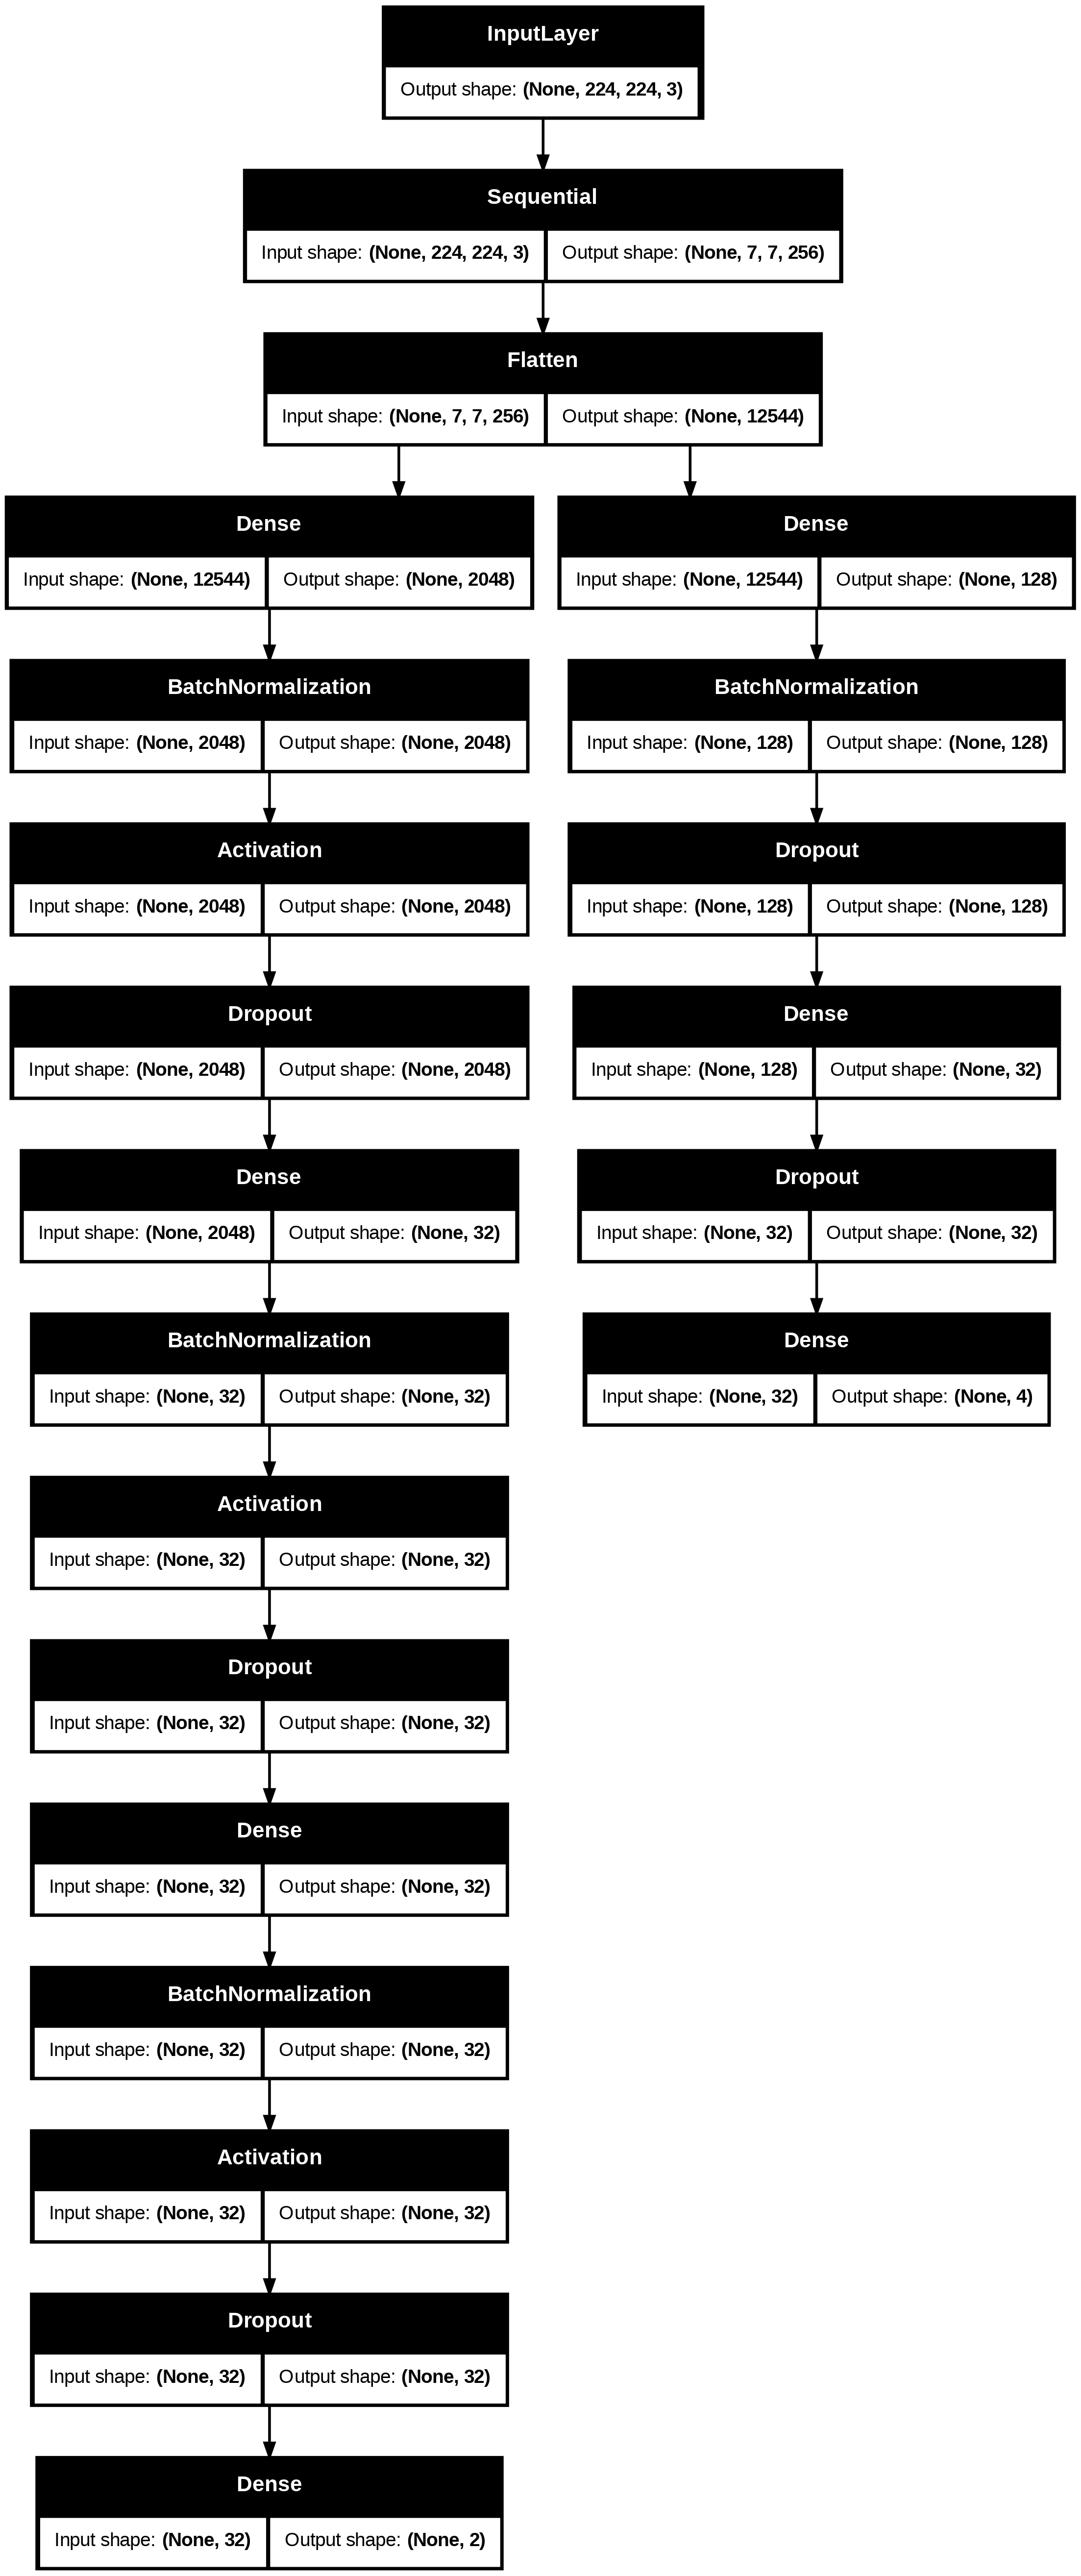

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Treinamento

In [52]:
# split = train_test_split(data, labels, coords, image_paths, test_size=0.3, random_state=42)

# (trainImages, valImages) = split[:2]
# (trainLabels, valLabels) = split[2:4]
# (trainCoords, valCoords) = split[4:6]
# (trainPaths, valPaths) = split[6:]

# trainTargets = {
# 	"class_output": trainLabels,
# 	"coords_output": trainCoords
# }

# valTargets = {
# 	"class_output": valLabels,
# 	"coords_output": valCoords
# }


# --- 1. Separar o Conjunto de Teste Final (20%) ---
# Separamos 20% dos dados para Teste e 80% para um conjunto temporário (temp).
# A lista de arrays de entrada deve ser a mesma na chamada de 'train_test_split'.
# Como 'split' é uma tupla sequencial (X_train, X_test, y_train, y_test, ...),
# usamos a concatenação para descompactar os 8 arrays de saída em 4 grupos (temp, test).

(
    # [data]
    data_temp, data_test,
    # [labels]
    labels_temp, labels_test,
    # [coords]
    coords_temp, coords_test,
    # [image_paths]
    paths_temp, paths_test
) = train_test_split(
    data, labels, coords, image_paths,
    test_size=0.2, # 20% para o conjunto de Teste
    random_state=42
)

# --- 2. Separar Treino e Validação (Dividindo os 80% restantes) ---
# Separamos o conjunto temporário (80%) em Treino (60% do total) e Validação (20% do total).
# 20% de Validação / 80% total temp = 0.25 (25% do conjunto temporário).

(
    # [data]
    trainImages, valImages,
    # [labels]
    trainLabels, valLabels,
    # [coords]
    trainCoords, valCoords,
    # [image_paths]
    trainPaths, valPaths
) = train_test_split(
    data_temp, labels_temp, coords_temp, paths_temp,
    test_size=0.25, # 25% do conjunto temporário
    random_state=42
)

# --- 3. Preparar os Dicionários de Targets para Keras ---
# Keras espera um dicionário mapeando o nome da camada de saída para o array de rótulos/coordenadas.

trainTargets = {
	"class_output": trainLabels,
	"coords_output": trainCoords
}

valTargets = {
	"class_output": valLabels,
	"coords_output": valCoords
}

testTargets = {
    "class_output": labels_test,
    "coords_output": coords_test
}


BATCH_SIZE=128
STEPS_PER_EPOCH= int(len(trainImages)/BATCH_SIZE)
EPOCHS = 15

history = model.fit(
	trainImages, trainTargets,
	validation_data=(valImages, valTargets),
	batch_size=BATCH_SIZE,
	epochs=EPOCHS,
  steps_per_epoch = STEPS_PER_EPOCH)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 339ms/step - class_output_accuracy: 0.5256 - class_output_loss: 0.7852 - coords_output_loss: 0.0709 - coords_output_mae: 0.2149 - loss: 5.5232 - val_class_output_accuracy: 0.7090 - val_class_output_loss: 17.4356 - val_coords_output_loss: 0.1112 - val_coords_output_mae: 0.2838 - val_loss: 22.8487
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - class_output_accuracy: 0.6036 - class_output_loss: 0.6985 - coords_output_loss: 0.0387 - coords_output_mae: 0.1583 - loss: 5.8838 - val_class_output_accuracy: 0.7090 - val_class_output_loss: 18.1133 - val_coords_output_loss: 0.1105 - val_coords_output_mae: 0.2827 - val_loss: 23.3042
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - class_output_accuracy: 0.6985 - class_output_loss: 0.6303 - coords_output_loss: 0.0350 - coords_output_mae: 0.1511 - loss: 4.7346 - val_class_output_accuracy: 0.7090 - val_class_output_loss: 4.8927 - val_coords_output_loss: 0.0554 - val_coords_output_mae: 0.1907 - val_l

In [11]:
history.history.keys()

dict_keys(['class_output_accuracy', 'class_output_loss', 'coords_output_loss', 'coords_output_mae', 'loss', 'val_class_output_accuracy', 'val_class_output_loss', 'val_coords_output_loss', 'val_coords_output_mae', 'val_loss'])

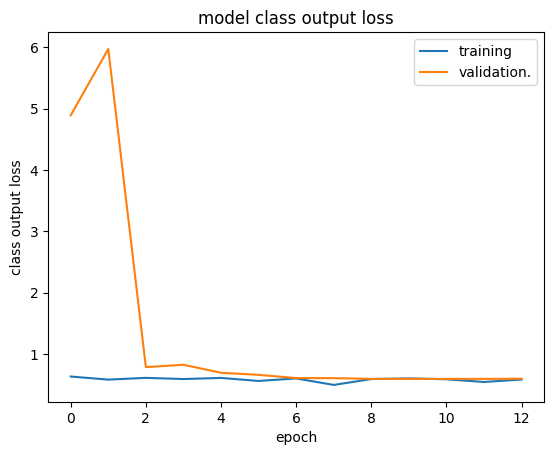

In [57]:
plot_train_valid_curves(history.history['class_output_loss'], history.history['val_class_output_loss'],  'class output loss')


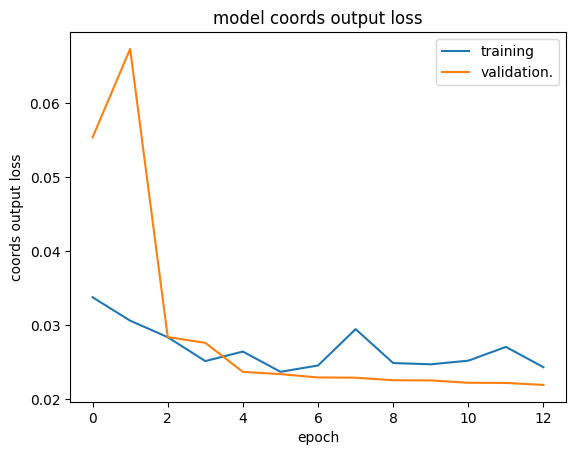

In [58]:
plot_train_valid_curves(history.history['coords_output_loss'],  history.history['val_coords_output_loss'], 'coords output loss')

# Teste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[0.2805042 0.7194958]
[0.2978072  0.10689845 0.7021297  0.6227523 ]


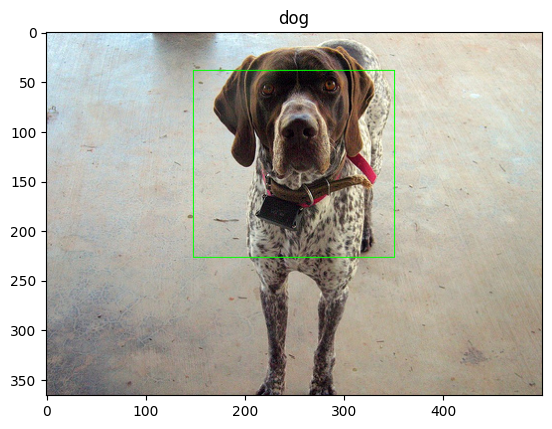

In [61]:
i = 13

(coordPreds, labelPreds) = model.predict(np.array([data_test[i]]))

print(labelPreds[0])
print(coordPreds[0])

show_image_boxes(paths_test[i], labelPreds[0], coordPreds[0])